# 오버워치 2 점수판 분석 AI

In [1]:
import os
import pandas as pd


def prepare_scoreboard(defeat_, draw_, victory_):
    scoreboard_ = pd.concat([defeat_, draw_, victory_])
    scoreboard_.set_index(pd.Index((i, j) for i in range(len(scoreboard_) // 10) for j in range(10)), inplace=True)
    return scoreboard_


datapath = os.path.join('datasets', '')
range_ = range(3, 10)
defeat = pd.read_csv(datapath + 'defeat.csv', usecols=range_)
draw = pd.read_csv(datapath + 'draw.csv', usecols=range_)
victory = pd.read_csv(datapath + 'victory.csv', usecols=range_)
scoreboard = prepare_scoreboard(defeat, draw, victory)
scoreboard

E   A   D   DMG      H   MIT    GAME
0   0   7   3   6  5933   1068  6199  DEFEAT
    1   7   0  10  3601    747     0  DEFEAT
    2   9   1   6  4352      0     0  DEFEAT
    3   7   7   2  2332   6325     0  DEFEAT
    4   6   4   2  3410   5979   606  DEFEAT
...    ..  ..  ..   ...    ...   ...     ...
205 5  11   4  11  6977    645  6378  DEFEAT
    6  10   0  13  7389      0   592  DEFEAT
    7  15   0  13  9338   1985   556  DEFEAT
    8   8  14   8  2859  10260   291  DEFEAT
    9   1  14  10   158  12357     0  DEFEAT

[2060 rows x 7 columns]

In [2]:
scoreboard.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2060 entries, (0, 0) to (205, 9)
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E       2060 non-null   int64 
 1   A       2060 non-null   int64 
 2   D       2060 non-null   int64 
 3   DMG     2060 non-null   int64 
 4   H       2060 non-null   int64 
 5   MIT     2060 non-null   int64 
 6   GAME    2060 non-null   object
dtypes: int64(6), object(1)
memory usage: 128.8+ KB


In [3]:
scoreboard['GAME'].value_counts()

GAME
DEFEAT     1005
VICTORY    1005
DRAW         50
Name: count, dtype: int64

In [4]:
scoreboard.describe()

,E,A,D,DMG,H,MIT
count,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000
mean,14.137379,7.571845,6.473786,6381.562621,3957.406311,2359.639320
std,10.343027,8.816635,3.911949,4704.827095,5262.560387,4754.326158
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,4.000000,2730.000000,0.000000,0.000000
50%,13.000000,4.000000,6.000000,5427.500000,829.000000,245.000000
75%,20.000000,12.000000,9.000000,9465.000000,7604.000000,1801.250000
max,56.000000,48.000000,21.000000,29354.000000,27756.000000,41092.000000


In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
IMAGES_PATH = os.path.join('.', 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장:', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

In [6]:
tank = scoreboard[::10]
damage = pd.concat([scoreboard[1::10], scoreboard[2::10]])
support = pd.concat([scoreboard[3::10], scoreboard[4::10]])

그림 저장: tank_hist


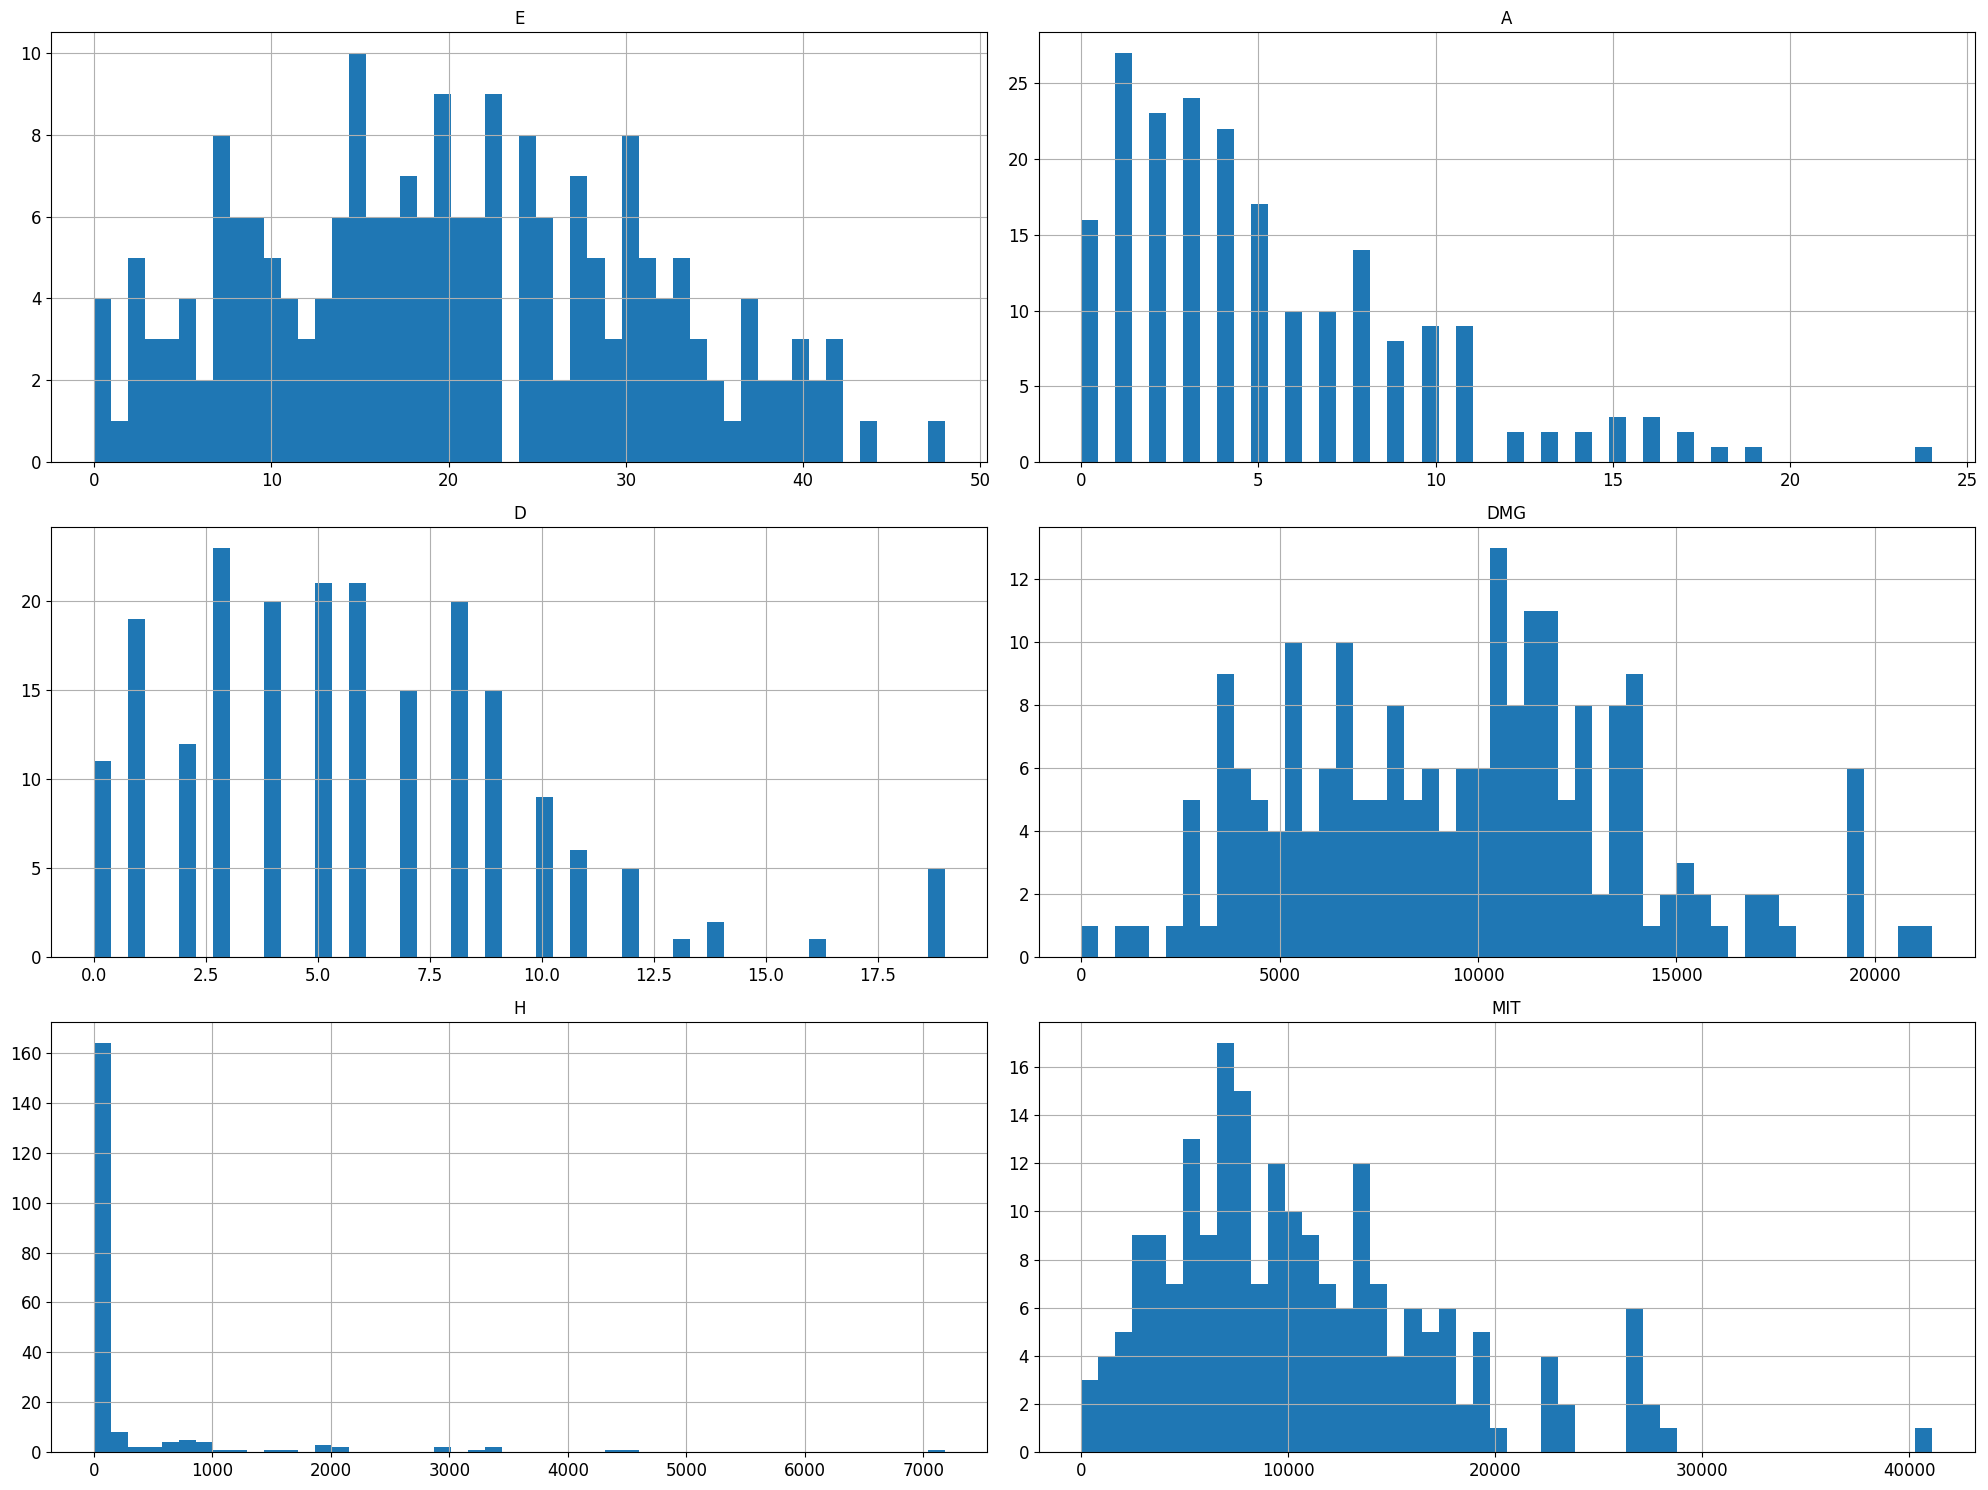

In [7]:
tank.hist(bins=50, figsize=(20, 15))
save_fig('tank_hist')
plt.show()

In [ ]:
damage.hist(bins=50, figsize=(20, 15))
save_fig('damage_hist')
plt.show()

그림 저장: damage_hist


In [ ]:
support.hist(bins=50, figsize=(20, 15))
save_fig('support_hist')
plt.show()

In [ ]:
import numpy as np

train_set = scoreboard.loc[np.random.default_rng().permutation(len(scoreboard) // 10)]

In [ ]:
scoreboard = train_set.copy()
# e = scoreboard['E'].copy()
# d = scoreboard['D'].copy()
# e[e == 0] = .5
# d[d == 0] = .5
# scoreboard['E_per_D'] = e / d
# scoreboard.describe()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
scoreboard_cat = train_set[['GAME']]
scoreboard_cat_encoded = ordinal_encoder.fit_transform(scoreboard_cat)
scoreboard_cat_encoded[:10]

In [ ]:
ordinal_encoder.categories_

In [ ]:
scoreboard_num.columns

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

scoreboard_num = train_set.drop('GAME', axis=1)
e_ix, a_ix, d_ix, dmg_ix, h_ix, mit_ix = [scoreboard_num.columns.get_loc(c) for c in scoreboard_num.columns]


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.to_numpy(np.float64)
        e = X[:, e_ix]
        a = X[:, a_ix]
        d = X[:, d_ix]
        dmg = X[:, dmg_ix]
        h = X[:, h_ix]
        mit = X[:, mit_ix]
        # e[e == 0] = 0.5
        # d[d == 0] = 0.5
        # e_per_d = e / d
        extra = a + d
        return np.c_[X, extra]


attr_adder = CombinedAttributesAdder()
scoreboard_extra_attribs = attr_adder.transform(scoreboard_num)
scoreboard_extra_attribs = pd.DataFrame(
    scoreboard_extra_attribs, scoreboard_num.index, list(scoreboard_num) + ['extra']
)
scoreboard_extra_attribs

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('attribs_adder', CombinedAttributesAdder()), ('std_scaler', StandardScaler())])
scoreboard_num_tr = num_pipeline.fit_transform(scoreboard_num)
scoreboard_num_tr

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

full_pipeline = ColumnTransformer(
    [('num', num_pipeline, scoreboard_num.columns), ('cat', OrdinalEncoder(), scoreboard_cat.columns)]
)
scoreboard_prepared = full_pipeline.fit_transform(train_set)
X = scoreboard_prepared[:, :-1]
shape_ = X.shape[-1]
X = X.reshape(-1, shape_ * 10)
y = scoreboard_prepared[::10, -1]

In [ ]:
X

In [ ]:
X.shape

In [ ]:
y

In [ ]:
y.shape

In [ ]:
from sklearn import ensemble, linear_model, neighbors, svm, tree
from sklearn.model_selection import cross_val_score

models = {
    'AdaBoostClassifier': ensemble.AdaBoostClassifier(),
    'BaggingClassifier': ensemble.BaggingClassifier(n_jobs=-1),
    'ExtraTreesClassifier': ensemble.ExtraTreesClassifier(n_jobs=-1),
    'GradientBoostingClassifier': ensemble.GradientBoostingClassifier(),
    'RandomForestClassifier': ensemble.RandomForestClassifier(n_jobs=-1),
    'HistGradientBoostingClassifier': ensemble.HistGradientBoostingClassifier(),
    'LogisticRegression': linear_model.LogisticRegression(max_iter=300, n_jobs=-1),
    'PassiveAggressiveClassifier': linear_model.PassiveAggressiveClassifier(n_jobs=-1),
    'Perceptron': linear_model.Perceptron(n_jobs=-1),
    'RidgeClassifier': linear_model.RidgeClassifier(),
    'SGDClassifier': linear_model.SGDClassifier(n_jobs=-1),
    'KNeighborsClassifier': neighbors.KNeighborsClassifier(n_jobs=-1),
    'RadiusNeighborsClassifier': neighbors.RadiusNeighborsClassifier(10., n_jobs=-1),
    'NearestCentroid': neighbors.NearestCentroid(),
    'LinearSVC': svm.LinearSVC(dual='auto', max_iter=2000),
    'NuSVC': svm.NuSVC(nu=.09),
    'SVC': svm.SVC(),
    'DecisionTreeClassifier': tree.DecisionTreeClassifier(),
    'ExtraTreeClassifier': tree.ExtraTreeClassifier()
}
scores = {}
for k, v in models.items():
    scores[k] = cross_val_score(v, X, y, n_jobs=-1).mean()
sorted_ = sorted(scores.items(), key=lambda item: item[1], reverse=True)
sorted_

In [ ]:
from sklearn.model_selection import cross_val_predict

transform = full_pipeline.named_transformers_.cat.inverse_transform
model = models[sorted_[0][0]]
for i, (y_true, y_pred) in enumerate(
        zip(transform(y.reshape(-1, 1)), transform(cross_val_predict(model, X, y, n_jobs=-1).reshape(-1, 1)))
):
    y_true, y_pred = y_true[0], y_pred[0]
    if y_true != y_pred:
        i = scoreboard.iloc[i * 10].name[0]
        defeats = len(defeat) // 10
        total = defeats + len(draw) // 10
        next_ = i + 1
        if i < defeats:
            print(f'{y_true} ({next_}) -> {y_pred} ({i})')
        elif i < total:
            print(f'{y_true} ({next_ - defeats}) -> {y_pred} ({i})')
        else:
            print(f'{y_true} ({next_ - total}) -> {y_pred} ({i})')
        print(scoreboard.loc[i], end='\n\n')

In [ ]:
for model, _ in sorted_:
    model = models[model].fit(X, y)
    if hasattr(model, 'feature_importances_'):
        print(model)
        importances = model.feature_importances_.reshape(-1, shape_)
        
        tank = importances[[0, 5]]
        damage = importances[[1, 2, 6, 7]]
        support = importances[[3, 4, 8, 9]]
        
        feature = '돌격 1인', '공격 1인', '지원 1인'
        
        print('\n**역할 중요도**')
        sum_ = tank.sum(), damage.sum() / 2, support.sum() / 2
        for s, f in sorted(zip(sum_, feature), reverse=True):
            print(f'{f}: {s * 100:.2f}%')

        feature = '처치', '도움', '죽음', '피해', '치유', '경감', 'EXTRA'
        
        print('\n**특성 중요도**')
        for s, f in sorted(zip(importances.sum(0), feature), reverse=True):
            print(f'{f}: {s * 100:.2f}%')
        
        print('\n**돌격 1인 특성 중요도**')
        for s, f in sorted(zip(tank.sum(0), feature), reverse=True):
            print(f'{f}: {s * 100:.2f}%')
        
        print('\n**공격 1인 특성 중요도**')
        for s, f in sorted(zip(damage.sum(0) / 2, feature), reverse=True):
            print(f'{f}: {s * 100:.2f}%')
        
        print('\n**지원 1인 특성 중요도**')
        for s, f in sorted(zip(support.sum(0) / 2, feature), reverse=True):
            print(f'{f}: {s * 100:.2f}%')
        
        break